In [1]:
# Import machine learning libraries
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid")

import time
from joblib import Parallel, delayed
from sklearn.base import clone

# Ensure output folders exist
os.makedirs('../results/visualizations', exist_ok=True)

print("✓ Machine learning libraries imported!")


✓ Machine learning libraries imported!


In [2]:
# Load the data we saved from the previous notebook
data_path = '../data/processed/misinformation_dataset.csv'
assert os.path.exists(data_path), f"File not found: {data_path}"

df = pd.read_csv(data_path)
print(f"✓ Loaded dataset: {df.shape}")

# Basic sanity
assert 'text' in df.columns and 'label' in df.columns, "Expected columns: 'text', 'label'"

# Prepare the data for machine learning
X_text = df['text'].fillna('')         # defensive: no NaNs
y = df['label']

# If labels are strings like {"real","misinfo"}, map to {0,1}
if y.dtype == object:
    mapping = {v:i for i, v in enumerate(sorted(df['label'].unique()))}
    print("Label mapping:", mapping)
    y = y.map(mapping)

print(f"✓ Text samples: {len(X_text)}")
print(f"✓ Labels: {len(y)}")


✓ Loaded dataset: (92394, 4)
✓ Text samples: 92394
✓ Labels: 92394


In [3]:
# Convert text to numbers using TF-IDF
print("Converting text to numbers...")

vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    max_features=20_000,
    min_df=2,
    stop_words="english",
    sublinear_tf=True,
    strip_accents="unicode",
    dtype=np.float32 
)

X = vectorizer.fit_transform(X_text)

print(f"✓ Feature matrix shape: {X.shape}")
print("✓ Text converted to numerical features")

# Split data into training and testing sets (stratify for label balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")


Converting text to numbers...
✓ Feature matrix shape: (92394, 20000)
✓ Text converted to numerical features
✓ Training set: 73915 samples
✓ Test set: 18479 samples


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

# Define different machine learning models to compare
models = {
    'Logistic Regression': LogisticRegression(
        class_weight="balanced",
        solver="liblinear",
        max_iter=1000,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    ),
    # NOTE: RBF SVM with probability=True is accurate but slow on large sparse text.
    # Used for  comparison, commented because taking longer runtime.
    # 'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42)

    'Linear SVM': LinearSVC(
        class_weight="balanced",
        random_state=42
    ),
}

print(f"✓ Defined {len(models)} models to compare")


✓ Defined 3 models to compare


In [5]:
# Standard library
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, precision_recall_curve   # <-- add these two
)

# Third-party
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

def _get_continuous_scores(model, X):
    """Prefer predict_proba; fall back to decision_function."""
    if hasattr(model, "predict_proba"):
        try:
            return model.predict_proba(X)
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            return model.decision_function(X)
        except Exception:
            pass
    return None

def _safe_roc_auc(y_true, scores):
    """Binary or multiclass AUC; returns None if not computable."""
    if scores is None:
        return None
    y_true = np.asarray(y_true)
    classes = np.unique(y_true)
    n_classes = len(classes)

    # Binary
    if n_classes == 2:
        if getattr(scores, "ndim", 1) == 2 and scores.shape[1] == 2:
            return roc_auc_score(y_true, scores[:, 1])
        if getattr(scores, "ndim", 1) == 1:
            return roc_auc_score(y_true, scores)
        return None

    # Multiclass (One-vs-Rest)
    if getattr(scores, "ndim", 1) == 2 and scores.shape[1] >= n_classes:
        return roc_auc_score(y_true, scores, multi_class="ovr", average="weighted")
    return None

# ---- Train & evaluate all models (with ROC-AUC when available) ----
results = {}
print("Training models...")

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall    = recall_score(y_test, y_pred,    average='macro', zero_division=0)
    f1        = f1_score(y_test, y_pred,        average='macro', zero_division=0)

    scores = _get_continuous_scores(model, X_test)
    roc_auc = _safe_roc_auc(y_test, scores)

    pr_auc = None
    if scores is not None:
        if hasattr(model, "predict_proba") and scores.ndim == 2:
            # positive class probability
            pos_scores = scores[:, 1]
            pr_auc = average_precision_score(y_test, pos_scores)
        elif scores is not None and getattr(scores, "ndim", 1) == 1:
            pr_auc = average_precision_score(y_test, scores)

    training_time = time.time() - start_time

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'training_time': training_time
    }

    msg = f"✓ {name}: Acc={accuracy:.3f}, Macro-F1={f1:.3f}"
    if roc_auc is not None:
        msg += f", ROC-AUC={roc_auc:.3f}"
    if pr_auc is not None:
        msg += f", PR-AUC={pr_auc:.3f}"
    print(msg)

print("\n✓ All models trained successfully!")


Training models...

Training Logistic Regression...
✓ Logistic Regression: Acc=0.970, Macro-F1=0.968, ROC-AUC=0.994, PR-AUC=0.987

Training Random Forest...
✓ Random Forest: Acc=0.972, Macro-F1=0.970, ROC-AUC=0.994, PR-AUC=0.984

Training Linear SVM...
✓ Linear SVM: Acc=0.973, Macro-F1=0.970, ROC-AUC=0.995, PR-AUC=0.989

✓ All models trained successfully!


In [7]:
# Create a results table
results_df = pd.DataFrame(results).T
print("=== MODEL COMPARISON RESULTS ===")
print(results_df.round(4))

# Sort the results by f1_score and pr_auc
sorted_results = results_df.sort_values(by=['f1_score','pr_auc'], ascending=False).round(4)
print(sorted_results)

# Get the name of the best model (index of the first row after sorting)
best_model = sorted_results.index[0]
best_score = results_df.loc[best_model, 'f1_score']

print(f"\n🏆 Best Model: {best_model}")
print(f"🎯 Best F1-Score: {best_score:.4f}")

=== MODEL COMPARISON RESULTS ===
                     accuracy  precision  recall  f1_score  roc_auc  pr_auc  \
Logistic Regression    0.9702     0.9622  0.9738    0.9675   0.9943  0.9869   
Random Forest          0.9725     0.9677  0.9719    0.9698   0.9937  0.9841   
Linear SVM             0.9728     0.9665  0.9744    0.9702   0.9946  0.9886   

                     training_time  
Logistic Regression         1.8603  
Random Forest              43.1891  
Linear SVM                  3.8320  
                     accuracy  precision  recall  f1_score  roc_auc  pr_auc  \
Linear SVM             0.9728     0.9665  0.9744    0.9702   0.9946  0.9886   
Random Forest          0.9725     0.9677  0.9719    0.9698   0.9937  0.9841   
Logistic Regression    0.9702     0.9622  0.9738    0.9675   0.9943  0.9869   

                     training_time  
Linear SVM                  3.8320  
Random Forest              43.1891  
Logistic Regression         1.8603  

🏆 Best Model: Linear SVM
🎯 Best F1-S

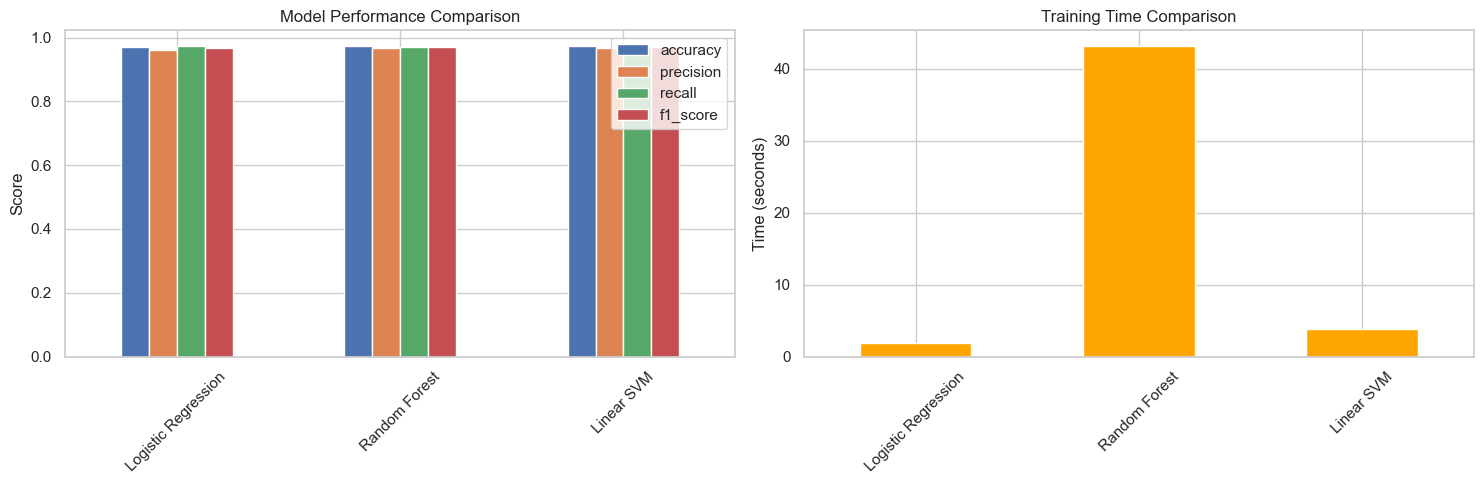

✓ Visualizations created and saved: ../results/visualizations/model_comparison.png


In [8]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Performance comparison chart
results_df[['accuracy', 'precision', 'recall', 'f1_score']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Performance Comparison')
axes[0].set_ylabel('Score')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# 2. Training time comparison
results_df['training_time'].plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Training Time Comparison')
axes[1].set_ylabel('Time (seconds)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
os.makedirs('../results/visualizations', exist_ok=True)
plt.savefig('../results/visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations created and saved: ../results/visualizations/model_comparison.png")


In [9]:
# Save all results
import json
os.makedirs('../results', exist_ok=True)

# Save results to JSON file (handle None for roc_auc)
results_for_json = {}
for model_name, metrics in results.items():
    clean = {}
    for k, v in metrics.items():
        if v is None:
            clean[k] = None
        else:
            clean[k] = float(v)
    results_for_json[model_name] = clean

with open('../results/model_results.json', 'w') as f:
    json.dump(results_for_json, f, indent=2)
print("✓ Results saved to ../results/model_results.json")

# Save the results table as CSV
results_df.to_csv('../results/model_comparison.csv')
print("✓ Results table saved to ../results/model_comparison.csv")

print("\n🎉 MACHINE LEARNING ANALYSIS COMPLETE!")
print(f"📊 Best performing model: {best_model}")
print(f"📁 All results saved to ../results/ folder")


✓ Results saved to ../results/model_results.json
✓ Results table saved to ../results/model_comparison.csv

🎉 MACHINE LEARNING ANALYSIS COMPLETE!
📊 Best performing model: Linear SVM
📁 All results saved to ../results/ folder
